<p style="text-align:center;">
<img src="https://github.com/digital-futures-academy/DataScienceMasterResources/blob/main/Resources/datascience-notebook-header.png?raw=true"
     alt="DigitalFuturesLogo"
     style="float: center; margin-right: 10px;" />
</p>

## TMDB movies
#### V1 Download

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast
from wordcloud import WordCloud

In [2]:
movies_filename = "TMDB_movies.csv"
df = pd.read_csv(movies_filename)
df.shape # number of rows and column

(4803, 20)

In [3]:
df.dtypes #types of data in each column

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [4]:
len(df.id.unique()) == len(df) ## check if the the id is unique

True

#### V2 Check NULL values

In [5]:
# Exploring if there are NULL values
null_vals = df.isnull().sum() # sum of NULL values in each column
total_cnt = len(df) # number of rows
null_vals = pd.DataFrame(null_vals,columns=['null']) # creating a dataframe to store the nulls
null_vals['percent'] = round((null_vals['null']/total_cnt)*100,3) # adding a row with the percentage of null values
null_vals

,null,percent
budget,0,0.000
genres,0,0.000
homepage,3091,64.356
id,0,0.000
keywords,0,0.000
original_language,0,0.000
original_title,0,0.000
overview,3,0.062
popularity,0,0.000
production_companies,0,0.000



**Two columns have significant amount of null values:**
* more than a half of movies do not have a homepage
* for 17.5% of movies tagline is not provided

We assume that having homepage and tagline is optional for the dataset.</p>

**Worth paying attention:**
<br>Few movies were not provided with the overview description, release_date and runtime.

In [6]:
df.loc[(df.release_date.isnull()) | (df.overview.isnull())|(df.runtime.isnull())][['title', 'release_date','runtime','overview']]

,title,release_date,runtime,overview
2656,Chiamatemi Francesco - Il Papa della gente,2015-12-03,NaN,NaN
4140,"To Be Frank, Sinatra at 100",2015-12-12,NaN,NaN
4431,Food Chains,2014-04-26,83.0,NaN
4553,America Is Still the Place,NaN,0.0,1971 post civil rights San Francisco seemed li...


**Runtime issue**
<br>Looks like the runtime column is inconsistent, because there are 35 rows having runtime  equal 0.

In [7]:
len(df.loc[df['runtime']==0][['id']])

35

#### V3 Genres, keywords and production companies

I decided to explore what are the most popular genres, what production companies we have in our dataset and what are the keywords. <br> To do this I needed to extract the information given to us as a dictionary. Using following functions I created lists of genres, production companies and keywords.

In [8]:
print(df.genres[0])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


In [9]:
def extract_name(string):
    ''' Take a single movie's genres and make them into a comma separated string '''
    string = ast.literal_eval(string) ## make sure it's a list!
    
    items = [x['name'] for x in string] ## Get a list of all names
    
    #return ",".join(genres) ## Join them all together as a string
    return items

In [10]:
df['genre_list']=df.genres.apply(extract_name).copy()
df['keywords_list'] = df.keywords.apply(extract_name).copy()
df['production_list'] = df.production_companies.apply(extract_name).copy()

In [11]:
def update_set(s: set, items: list):
    '''Fills set with items in the list'''
    for item in items:
        s.add(item)

def extract_all_list_items(df, field_name):
    '''Creates a set of unique items in a column'''
    result = set()

    df[field_name].apply(lambda x: (update_set(result, x)))

    return result

In [12]:
# creating sets of unique genres, keywords and production companies
unique_genres = extract_all_list_items(df, 'genre_list')
unique_keywords = extract_all_list_items(df, 'keywords_list')
unique_productions = extract_all_list_items(df, 'production_list')

In [13]:
len(unique_genres)

20

In [14]:
len(unique_productions)

5017

In [15]:
len(unique_keywords)

9813

Now we understand that we have 20 genres, over 5000 production companies and almost 10 000 keywords!

#### V4 Most popular keywords, genres and production companies

##### Code

In [16]:
def get_movies_by_item(src, item_list, list_name):
    '''
    Returns dictionary of number of movies per item in the list column (genres, keywords, production)
    '''
    result = {}

    # Apply changes
    for item in item_list:
        filtered = src[src[list_name].apply(lambda items: item in items)]
        val = result.get(item, 0)
        result[item] = val + len(filtered)

    return result

def get_revenue_by_item(src, item_list, list_name):
    '''
    Returns dictionary of total revenues per item in the list column (genres, keywords, production)
    '''
    result = {}
    
    total = src['revenue'].sum()
    for item in item_list:
        filtered = src[src[list_name].apply(lambda items: item in items)]
        result[item] = filtered['revenue'].sum()/total*100

    return result

def convert_to_proper_dict(src: dict, column_name):
    '''
    Converts dictionary to create a dataframe
    '''
    res = {}

    res[column_name] = list(src.keys())
    res['values'] = list(src.values())

    return res

def calculate_data_for_item(df, func, item_list, list_name, head_num = 15):
    '''
    df source data set
    func the function to be used
    item_list list of items (unique list of genres/keywords/productions)
    list_name name of the column with the corresponding list 
    '''
    data = func(df, item_list, list_name)
    data_frame = pd.DataFrame.from_dict(
        convert_to_proper_dict(data, 'keys'))
    data_frame = data_frame.sort_values(
        by='values', ascending=False).head(head_num)
    
    return (data, data_frame)

##### Visualisations

I calculated number of films and total revenue for the most popular **keywords**.

In [17]:
# Calculate number of movies and revenues per keyword
keyword_data, keyword_df = calculate_data_for_item(
    df, get_movies_by_item, unique_keywords, 'keywords_list')
keyword_revenue_data, keyword_revenue_df = calculate_data_for_item(
    df, get_revenue_by_item, unique_keywords, 'keywords_list')

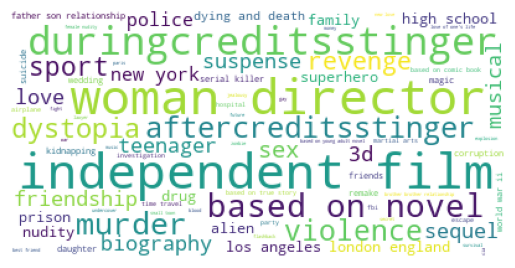

In [18]:
#keywordcloud by number of films
keyword_cloud = WordCloud(background_color="white",
                      max_font_size=40,
                      relative_scaling=.5).generate_from_frequencies(keyword_data)
plt.figure()
plt.imshow(keyword_cloud)
plt.axis("off")
plt.show()

*Most frequent keywords:*<br>As we can see, the movies marked as 'woman director', 'independent film' are the most frequent in our table.

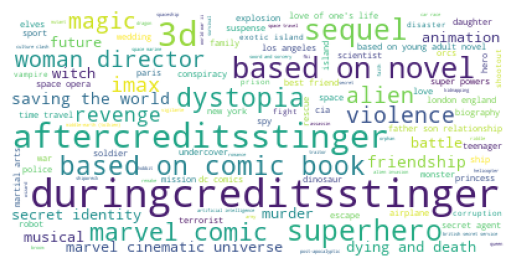

In [19]:
# keywordcloud by revenue
keyword_revenues = WordCloud(background_color="white",
                           max_font_size=40,
                           relative_scaling=.5).generate_from_frequencies(keyword_revenue_data)
plt.figure()
plt.imshow(keyword_revenues)
plt.axis("off")
plt.show()

*Most selling keywords:*
<br>On the other hand, the most selling movies are not the independent ones. The leaders are 'based on comic books', 3d, 'superhero' etc.

After that I calculated number of movies and total revenue per **genre**. Each film has multiple genres, but we can see what are the most frequent in our database and what genres produce more revenue.

In [20]:
# Calculate number of movies and revenues per genre
genre_data, genre_df = calculate_data_for_item(
    df, get_movies_by_item, unique_genres, 'genre_list')
genre_revenue_data, genre_revenue_df = calculate_data_for_item(
    df, get_revenue_by_item, unique_genres, 'genre_list')

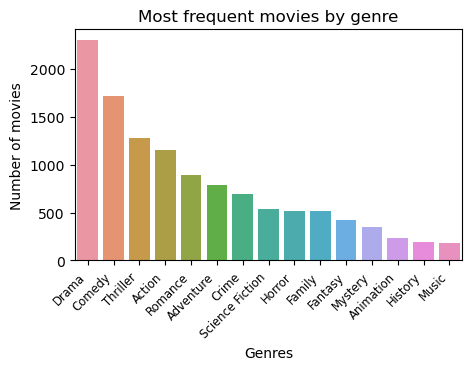

In [21]:
plt.figure(figsize=(5,3))
sns.barplot(data=genre_df, x='keys', y='values')
plt.title('Most frequent movies by genre')
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight='light',
           fontsize='small'
           )
plt.show()

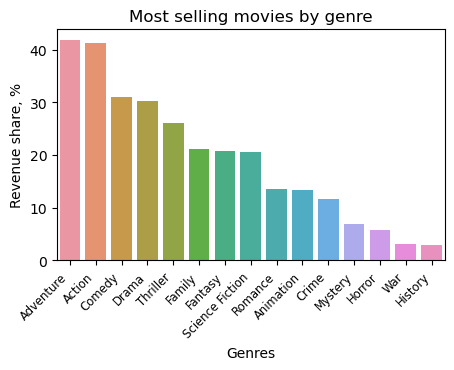

In [22]:
plt.figure(figsize=(5, 3))
sns.barplot(data=genre_revenue_df, x='keys', y='values')
plt.title('Most selling movies by genre')
plt.xlabel('Genres')
plt.ylabel('Revenue share, %')
plt.xticks(rotation=45,
           horizontalalignment='right',
           fontweight='light',
           fontsize='small'
           )
plt.show()

Three most frequent genres are drama, comedy and thriller, but most selling genres are adventure, action and comedy.
We can also see that there numerous romantic films, but in terms of the revenue rank they are not the leaders.

Then I decided to calculate a number of movies and total revenue per **production company**, to find the most 'productive' production companies.

In [ ]:
# Calculate number of movies and revenues per production company
company_data, company_df = calculate_data_for_item(
    df, get_movies_by_item, unique_productions, 'production_list', 100)
company_revenue_data, company_revenue_df = calculate_data_for_item(
    df, get_revenue_by_item, unique_productions, 'production_list', 100)

In [ ]:
company_df = company_df.rename(columns = {'keys': 'Production Company', 'values': 'Number of filmes'})
company_df.head(15)

In [ ]:
company_revenue_df = company_revenue_df.rename(columns = {'keys': 'Production Company', 'values': 'Total revenue'})
company_revenue_df.head(15)

In [ ]:
production_companies = company_df.merge(company_revenue_df, how='outer')
production_companies.head(15)

Based on the calculations above, we can say that the three leading production companies Warner Bros., Universal Pictures and Paramount Pictures are top-3 in terms of number of movies and total revenue as well.

#### V5 Two films comparison

Let's describe two filmes:
* Cloud Atlas as an example of an independant film with a woman director
* Avengers: Age of Ultron as an example of 3d and based on comic book

Cloud Atlas keywords are: clone, future, dystopia, ensemble cast, duringcreditsstinger, century, woman director, 1930s.
<br>Avengers: Age of Ultron keywords are marvel comic, sequel, superhero, based on comic book, vision, superhero team, duringcreditsstinger, marvel cinematic universe, 3d

In [ ]:
movies_df = df.loc[df['original_title'].isin(['Cloud Atlas','Avengers: Age of Ultron'])][['original_title','popularity','vote_count','budget','revenue']]
movies_df

Let's compare there budgets and revenues. Both films are high budget and profitable.

In [ ]:
movies_df['net_income'] = movies_df['revenue'] - movies_df['budget']
movies_df['profit_margin %'] = (movies_df['revenue'] / movies_df['budget'] *100).round(1)
movies_df

Independent films are for true connoisseurs and are not always as profitable as films based on comics.
Marvel universe films have higher vote counts.